# Variable construction 

In this notebook I construct my variables for the final dataset. There are some notes about the taken choices made along the way. 

#### Data Processing

First reading in pre-processed data and loading packages

In [1]:
# libs
import spacy
import pandas as pd
import numpy as np
from funcs import ExtractNameYear, ExtractFileName, ExtractAllText, ComputeGreenInd, TransformReturns, TransformIndices, MakeReturnsInd, MakeReturns, AbnormalReturns
from datetime import datetime

#### Loading the NLP models

NLP model and greenwashing indicator (but first checking if I can use my GPU)

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))



True
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


Classifying paragraphs into climate related/not related

In [3]:
# importing the model stuff
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

In [4]:
model_name_class = "climatebert/distilroberta-base-climate-detector"

# If you want to use your own data, simply load them as 🤗 Datasets dataset, see https://huggingface.co/docs/datasets/loading

model_class = AutoModelForSequenceClassification.from_pretrained(model_name_class)
tokenizer_class = AutoTokenizer.from_pretrained(model_name_class, max_len=512)

pipe_class = pipeline("text-classification", model=model_class, tokenizer=tokenizer_class, device=0)

Device set to use cuda:0


*CLIMATEBERT* for checking the specificity of climate-related paragraphs **TESTS**

In [5]:
model_name_spec = "climatebert/distilroberta-base-climate-specificity"

model_spec = AutoModelForSequenceClassification.from_pretrained(model_name_spec)
tokenizer_spec = AutoTokenizer.from_pretrained(model_name_spec, max_len=512)

pipe_spec = pipeline("text-classification", model=model_spec, tokenizer=tokenizer_spec, device=0)

Device set to use cuda:0


#### Data

In [2]:
# data on greenwashing companies
data_greenwashing = pd.read_excel('../data/LSEG data/matched_final.xlsx', sheet_name='companies')


In [ ]:
# monthly returns
# data_returns_m = pd.read_excel('../data/LSEG data/matched_final.xlsx', sheet_name='indicators_1')
# data_indices_m = pd.read_excel('../data/LSEG data/matched_final.xlsx', sheet_name='INDICES_monthly', skiprows=3)

In [ ]:
# weekly returns
# data_returns_w = pd.read_excel('../data/LSEG data/matched_final.xlsx', sheet_name='indicators_2', skiprows=3)
# data_indices_w = pd.read_excel('../data/LSEG data/matched_final.xlsx', sheet_name='INDICES_weekly', skiprows=3)

In [3]:
# daily returns
data_returns_d = pd.read_excel('../data/LSEG data/matched_final.xlsx', sheet_name='indicators_3', skiprows=3)
data_indices_d = pd.read_excel('../data/LSEG data/matched_final.xlsx', sheet_name='INDICES_daily', skiprows=3)

In [4]:
# sales
data_sales = pd.read_excel('../data/LSEG data/matched_final.xlsx', sheet_name='indicators_4.1', skiprows=3)

In [5]:
# processing returns and merging to greenwashing


# data_returns_m = TransformReturns(data_returns_m, data_greenwashing, old=True)
# data_returns_w = TransformReturns(data_returns_w, data_greenwashing)
data_returns_d = TransformReturns(data_returns_d, data_greenwashing)



c:\Users\Jakub\Documents\Studies\BSc Econ\subjects\6-semester\thesis\code\funcs.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"NAME"] = df.loc[:,"Name"].str.removesuffix(' - PRICE INDEX')
c:\Users\Jakub\Documents\Studies\BSc Econ\subjects\6-semester\thesis\code\funcs.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "VARIABLE"] = np.where(df.loc[:,"Name"].str.contains(" - PRICE INDEX"), 'PRICE INDEX', pd.NA)
c:\Users\Jakub\Documents\Studies\BSc Econ\subjects\6-semester\thesis\

In [6]:
# data_indices_m = TransformIndices(data_indices_m)
# data_indices_w = TransformIndices(data_indices_w, weekly=True)
data_indices_d = TransformIndices(data_indices_d)


#### Transforming the sales data

In [ ]:
data_sales.loc[:, "VARIABLE"] = np.where(data_sales.loc[:,"Name"].str.contains("- QUARTER 1"), 'Q1', pd.NA)
data_sales.loc[:, "VARIABLE"] = np.where(data_sales.loc[:,"Name"].str.contains("- QUARTER 2"), 'Q2', data_sales.loc[:, "VARIABLE"])
data_sales.loc[:, "VARIABLE"] = np.where(data_sales.loc[:,"Name"].str.contains("- QUARTER 3"), 'Q3', data_sales.loc[:, "VARIABLE"])
data_sales.loc[:, "VARIABLE"] = np.where(data_sales.loc[:,"Name"].str.contains("- QUARTER 4"), 'Q4', data_sales.loc[:, "VARIABLE"])


data_sales.loc[:,"NAME"] = data_sales.loc[:,"Name"].str.replace(r"- INTERIM SALES - QUARTER \d{1}", "", regex=True)
data_sales.dropna(subset=["VARIABLE"], inplace=True)
data_sales[["TYPE", "VAR_CODE"]] = data_sales["Code"].str.split("(", n=1, expand=True)
data_sales.drop(columns=['Name', 'Code', 'VAR_CODE'], inplace=True)


data_sales = pd.melt(data_sales, id_vars=['NAME', "TYPE", "VARIABLE"]).rename(columns={'variable':'DATE', 
                                                                         'value':'SALES'})

data_sales["SALES"] = data_sales["SALES"].astype(float)
data_sales[["QUARTER", "YEAR"]] = data_sales["DATE"].str.split(" ", n=1, expand=True)
data_sales["DATE"] = data_sales["YEAR"] + " " + data_sales["QUARTER"]

data_sales=data_sales.loc[:, ['NAME', 'TYPE','DATE','YEAR','QUARTER','SALES']].sort_values(["NAME", 'YEAR',"QUARTER"])


from itertools import product
# making sure that all firms have data starting from the same date
full_index = pd.DataFrame(product(data_sales["NAME"].unique(), data_sales["DATE"].unique()))
full_index.columns = ["NAME", "DATE"]

data_sales.dropna(subset=["SALES"], inplace=True)

data_sales = full_index.merge(data_sales, how="left", on=['NAME', 'DATE'])

data_sales = data_sales.groupby("NAME").filter(lambda x: ~x["SALES"].isna().any())
data_sales = data_sales.groupby("NAME").filter(lambda x: (x["SALES"]>0).all())



**Calculating the log differences for sales** \
\
Here I will surely have some missing data, and so I am trying to make the log_change_sales such that there's no loss of variables. **NOTE** I will need to adjust for seasonality in sales! \
\
I WILL DEFINITELY NEED TALK ABOUT THE EXCLUSION OF FIRMS IN MY SAMPLES - AFTER ALL, A LOT OF FIRMS DROPS OUT!!!

In [6]:
data_sales["LOG_SALES"] = np.log((data_sales["SALES"]))
data_sales["LOG_SALES_DIFF"] = data_sales.groupby(by='NAME')['LOG_SALES'].diff()
data_sales.to_csv("../data/output/data_sales.csv", index=False)

#### Calculating abnormal returns

Here I calculate abnormal returns and cumulative abnormal returns. In order to do that, I benchmark the realized returns of each of the companies against their expected return. The market model is estimated in order to assess the expected return. The market for each security is chosen with respect to the primary market of operations of each company (S&P for the USA/Canada, MSCI EUROPE for Europe, ... **Work-in-progress, need to get indices for more geographical regions**). Finally, I chose to use the price return on equity only (instead of total return including re-invested dividends - they don't really matter over such a short period anyway)

In [7]:
# check to see the market from which most of the companies come from ("Country of Domicile")
print(data_greenwashing['CTRY_OF_DOM_NAME'].value_counts(normalize=True))


# data_returns_m = MakeReturns(data_returns_m)
# data_returns_w = MakeReturns(data_returns_w)
data_returns_d = MakeReturns(data_returns_d)


# data_indices_m = MakeReturnsInd(data_indices_m)
# data_indices_w = MakeReturnsInd(data_indices_w)
data_indices_d = MakeReturnsInd(data_indices_d)


CTRY_OF_DOM_NAME
UNITED STATES           0.621881
AUSTRALIA               0.093090
UNITED KINGDOM          0.092131
CANADA                  0.071977
CHINA                   0.011996
IRELAND                 0.010557
BERMUDA                 0.009117
NEW ZEALAND             0.007198
ISRAEL                  0.007198
SWITZERLAND             0.005278
BRAZIL                  0.004319
MEXICO                  0.003839
GREECE                  0.003839
NETHERLANDS             0.003359
INDIA                   0.003359
SINGAPORE               0.003359
GERMANY                 0.002879
LUXEMBOURG              0.002879
CAYMAN ISLANDS          0.002879
TAIWAN                  0.002879
JAPAN                   0.002879
CHILE                   0.002399
SOUTH KOREA             0.002399
ARGENTINA               0.002399
PUERTO RICO             0.001919
BELGIUM                 0.001440
DENMARK                 0.001440
MONACO                  0.001440
GUERNSEY                0.001440
HONG KONG               0.

c:\Users\Jakub\Documents\Studies\BSc Econ\subjects\6-semester\thesis\code\funcs.py:259: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['STOCK_PCT_RETURN'] = df.groupby(by='NAME')['PRICE INDEX'].apply(pd.Series.pct_change).reset_index()['PRICE INDEX']


Checking for duplicated data in the companies. It seems that some have been duplicated but mostly due to having a subsidiary in the same name/having multiple pages etc. 
Some of them are also the wrong company. There's little enough problems though, that it seems like it could be dropped (16 companies like that) 

In [8]:
# print(data_returns_m[['NAME', 'DATE']].value_counts())
# print(data_returns_w[['NAME', 'DATE']].value_counts())
# print(data_returns_d[['NAME', 'DATE']].value_counts())

# data_returns_m.drop_duplicates(subset=['NAME', 'DATE'], inplace=True)
# data_returns_w.drop_duplicates(subset=['NAME', 'DATE'], inplace=True)
data_returns_d.drop_duplicates(subset=['NAME', 'DATE'], inplace=True)


In [12]:
market_dict = {
                # S&P 500
                "UNITED STATES":"S&P 500 COMPOSITE",
                "CANADA":"S&P 500 COMPOSITE",
                "BERMUDA":"S&P 500 COMPOSITE",
                "CAYMAN ISLANDS":"S&P 500 COMPOSITE",
                
                # MSCI EM MARKETS AMERICA
                "MEXICO":"MSCI EM LATIN AMERICA U$",
                "PUERTO RICO":"MSCI EM LATIN AMERICA U$",
                "COSTA RICA":"MSCI EM LATIN AMERICA U$",
                "BARBADOS":"MSCI EM LATIN AMERICA U$",
                "PANAMA":"MSCI EM LATIN AMERICA U$",
                "COLOMBIA":"MSCI EM LATIN AMERICA U$",
                "BRAZIL":"MSCI EM LATIN AMERICA U$",
                "CHILE":"MSCI EM LATIN AMERICA U$",
                "PERU":"MSCI EM LATIN AMERICA U$",
                "URUGUAY":"MSCI EM LATIN AMERICA U$",
                "ARGENTINA":"MSCI EM LATIN AMERICA U$",
                
                # MSCI europe
                "UNITED KINGDOM":"MSCI EUROPE U$",
                "IRELAND":"MSCI EUROPE U$",
                "SWITZERLAND":"MSCI EUROPE U$",
                "NETHERLANDS":"MSCI EUROPE U$",
                "GREECE":"MSCI EUROPE U$",
                "GERMANY":"MSCI EUROPE U$",
                "BELGIUM":"MSCI EUROPE U$",
                "DENMARK":"MSCI EUROPE U$",
                "MONACO":"MSCI EUROPE U$",
                "LUXEMBOURG":"MSCI EUROPE U$",
                "FRANCE":"MSCI EUROPE U$",
                "SWEDEN":"MSCI EUROPE U$",
                "ISLE OF MAN":"MSCI EUROPE U$",
                "SPAIN":"MSCI EUROPE U$",
                "FINLAND":"MSCI EUROPE U$",
                "ROMANIA":"MSCI EUROPE U$",
                "ITALY":"MSCI EUROPE U$",
                "AUSTRIA":"MSCI EUROPE U$",
                "JERSEY":"MSCI EUROPE U$",
                "GUERNSEY":"MSCI EUROPE U$",
                "TURKEY":"MSCI EUROPE U$",
                
                
                # msci pacific
                "HONG KONG":"MSCI PACIFIC U$",
                "SINGAPORE":"MSCI PACIFIC U$",
                "JAPAN":"MSCI PACIFIC U$",
                "AUSTRALIA":"MSCI PACIFIC U$",
                "NEW ZEALAND":"MSCI PACIFIC U$",
                "PAPUA NEW GUINEA":"MSCI PACIFIC U$",
                
                # MSCI AC ASIA
                "CHINA":"MSCI AC ASIA U$",
                "INDIA":"MSCI AC ASIA U$",
                "SOUTH KOREA":"MSCI AC ASIA U$",
                "TAIWAN":"MSCI AC ASIA U$",
                "MONGOLIA":"MSCI AC ASIA U$",
                "INDONESIA":"MSCI AC ASIA U$",
                "PHILIPPINES":"MSCI AC ASIA U$",
                
                # MSCI WORLD
                "ISRAEL":"MSCI WORLD U$",
                "KAZAKHSTAN":"MSCI WORLD U$",
                "UNITED ARAB EMIRATES":"MSCI WORLD U$",
                "SOUTH AFRICA":"MSCI WORLD U$",
                
                # missing values
                np.nan:'NA'
               
    
}

exchange_mrkt_dict = {
# US
"Nasdaq":"S&P 500 COMPOSITE",
"Toronto SE":"S&P 500 COMPOSITE",
"NYSE":"S&P 500 COMPOSITE",

# Europe
"London SE":"MSCI EUROPE U$",       
"Euronext Amsterdam":"MSCI EUROPE U$",
"NASDAQ Stockholm":"MSCI EUROPE U$",
"Boerse Frankfurt" :"MSCI EUROPE U$",
"Euronext Paris":"MSCI EUROPE U$",
"Six Swiss Exchange":"MSCI EUROPE U$",
"Euronext Brussels" :"MSCI EUROPE U$",
"Borsa Italiana":"MSCI EUROPE U$",
"Oslo Bors":"MSCI EUROPE U$",
"Wiener Boerse AG":"MSCI EUROPE U$",
"Athens SE" :"MSCI EUROPE U$",
"NASDAQ Helsinki":"MSCI EUROPE U$",
"NASDAQ Copenhagen":"MSCI EUROPE U$",
"Boerse Hamburg":"MSCI EUROPE U$",
"BME Exchange":"MSCI EUROPE U$",
"Ljubljana SE":"MSCI EUROPE U$",

# Pacific
"Tokyo SE":"MSCI PACIFIC U$",
"Hong Kong Exchange":"MSCI PACIFIC U$",
"Singapore Exchange":"MSCI PACIFIC U$",
"Australian SE":"MSCI PACIFIC U$",
"New Zealand Exchange":"MSCI PACIFIC U$",

# Asia
"Korea Exchange":"MSCI AC ASIA U$",    
"Taiwan SE":"MSCI AC ASIA U$",
"National SE":"MSCI AC ASIA U$",

# latin america
"Santiago SE":"MSCI EM LATIN AMERICA U$",
"Bolsa Mexicana":"MSCI EM LATIN AMERICA U$",

# Other
"Egyptian Exchange":"MSCI WORLD U$",
"Johannesburg SE":"MSCI WORLD U$",
np.nan:'NA'
}


# data_abnormal_returns_m = AbnormalReturns(data_returns_m, data_indices_m,  market_dict, "2014-01-01", "2018-06-01", "STOCK_LOG_RETURN", "INDEX_LOG_RETURN")
# data_abnormal_returns_w = AbnormalReturns(data_returns_w, data_indices_w,  market_dict, "2016-01-01", "2019-07-01", "STOCK_LOG_RETURN", "INDEX_LOG_RETURN")
data_abnormal_returns_d = AbnormalReturns(data_returns_d, data_indices_d,  market_dict, exchange_mrkt_dict, "2019-01-01", "2019-08-01", "STOCK_LOG_RETURN", "INDEX_LOG_RETURN")


# data_abnormal_returns_m.to_csv("../data/output/data_abnormal_returns_m.csv", index=False)
# data_abnormal_returns_w.to_csv("../data/output/data_abnormal_returns_w.csv", index=False)
data_abnormal_returns_d.to_csv("../data/output/data_abnormal_returns_d.csv", index=False)


c:\Users\Jakub\Documents\Studies\BSc Econ\subjects\6-semester\thesis\code\funcs.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_abnormal_returns['NORMAL_RETURN'] = pd.NA


3I GROUP
nan
London SE
MSCI EUROPE U$
3I INFRASTRUCTURE
nan
London SE
MSCI EUROPE U$
3M
UNITED STATES
NYSE
5N PLUS
CANADA
Toronto SE
AALBERTS
nan
Euronext Amsterdam
MSCI EUROPE U$
AAON
UNITED STATES
Nasdaq
AAR
UNITED STATES
NYSE
ABBOTT LABORATORIES
UNITED STATES
NYSE
ABBVIE
UNITED STATES
NYSE
ABERDEEN GROUP
UNITED KINGDOM
London SE
ABM INDS.
UNITED STATES
NYSE
ABN AMRO BANK
nan
Euronext Amsterdam
MSCI EUROPE U$
ABSA GROUP
nan
Johannesburg SE
MSCI WORLD U$
Skip ABSA GROUP because invalid index
ACADIA HEALTHCARE CO.
UNITED STATES
Nasdaq
ACCENT GROUP
AUSTRALIA
Australian SE
ACCENTURE CLASS A
IRELAND
NYSE
ACCO BRANDS
UNITED STATES
NYSE
ACCSYS TECHNOLOGIES
UNITED KINGDOM
London SE
ACI WORLDWIDE
UNITED STATES
Nasdaq
ACUITY
UNITED STATES
NYSE
ADEIA
UNITED STATES
Nasdaq
ADENTRA
CANADA
Toronto SE
ADIDAS
nan
Boerse Frankfurt
MSCI EUROPE U$
ADIENT
IRELAND
NYSE
ADMIRAL GROUP
UNITED KINGDOM
London SE
ADOBE (NAS)
UNITED STATES
Nasdaq
ADRIATIC METALS
nan
nan
NA
Skip ADRIATIC METALS because invalid in

### Transforming the greenwashing dataset
Making one observation per sustainability report

In [7]:
# /////////////////////////////////////
#       expanding
# /////////////////////////////////////

data_greenwashing['REPORT_LISTS'] = data_greenwashing['REPORT_LISTS'].apply(eval)

# Expand each list entry into its own row
data_greenwashing = data_greenwashing.explode('REPORT_LISTS', ignore_index=True)

data_greenwashing['YEAR'] = data_greenwashing['REPORT_LISTS'].str.extract(r'(\d+)')
data_greenwashing['YEAR'] = data_greenwashing['YEAR'].astype(float)

data_greenwashing.to_csv("../data/output/company_characteristics.csv", index=False)

In [ ]:
# get datasets that have a 2017 sustainability report

greenwashing_2017 = data_greenwashing[data_greenwashing["YEAR"]==2017]
names_2017 = greenwashing_2017["NAME_SCRAPED"]

#### Greenwashing Indicator - **2017**

Expanding the dataset to have one observation per sustainability report and calculating the number of reports per year.

In [5]:
print(greenwashing_2017.value_counts("CTRY_OF_DOM_NAME"))

CTRY_OF_DOM_NAME
UNITED STATES           296
UNITED KINGDOM           65
CANADA                   55
AUSTRALIA                38
IRELAND                   8
MEXICO                    7
BERMUDA                   6
SWITZERLAND               6
NEW ZEALAND               6
INDIA                     5
JAPAN                     4
CHILE                     4
TAIWAN                    4
SOUTH KOREA               4
SINGAPORE                 3
NETHERLANDS               3
LUXEMBOURG                3
BRAZIL                    3
ARGENTINA                 2
SPAIN                     2
FRANCE                    2
PANAMA                    2
CHINA                     2
SWEDEN                    2
DENMARK                   2
UNITED ARAB EMIRATES      1
COLOMBIA                  1
ITALY                     1
ISRAEL                    1
ROMANIA                   1
PHILIPPINES               1
PAPUA NEW GUINEA          1
GERMANY                   1
FINLAND                   1
Name: count, dtype: int64


Converting the 2017 sustainability reports into lists of files

In [ ]:
nlp = spacy.load('en_core_web_sm')

input_name = "C:/Users/Jakub/OneDrive - Tilburg University/thesis data/responsibility reports"

filenames = ExtractFileName(series_names=names_2017, input_dir=input_name, year_str="2017")

names_2017_updated = names_2017.str.lower().str.replace(" ", "_").str.replace("?", "").str.replace("|", "")
names_2017_updated = names_2017_updated.loc[~(names_2017_updated.isin(filenames.keys()))]

filenames_updated = ExtractNameYear(series_names=names_2017_updated, input_dir=input_name, nlp_model=nlp, year_str="2017")

filenames.update(filenames_updated)

Dumping all of the text from PDF files into their respective TXT files for later processing

In [6]:
ExtractAllText(filenames, "2017", "../data/text_processing")

Here I need to load all of the files in a loop, then categorize them, subset the categorized ones and within those classify some as specific and nonspecific and then compute the prop of non-specific

In [ ]:
greenwashing_ind = ComputeGreenInd(names_2017, "../data/text_processing/2017", pipe_class, pipe_spec)

greenwashing_ind.to_csv("../data/text_processing/greenwashing_ind_2017.csv")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


#### Greenwashing Indicator - **2018**

In [26]:
# get datasets that have a 2017 sustainability report

greenwashing_2018 = data_greenwashing[data_greenwashing["YEAR"]==2018]
names_2018 = greenwashing_2018["NAME_SCRAPED"]

Expanding the dataset to have one observation per sustainability report and calculating the number of reports per year.

In [ ]:
print(greenwashing_2018.value_counts("CTRY_OF_DOM_NAME"))

Converting the 2018 sustainability reports into lists of files

In [10]:
nlp = spacy.load('en_core_web_sm')

input_name = "C:/Users/Jakub/OneDrive - Tilburg University/thesis data/responsibility reports"

filenames = ExtractFileName(series_names=names_2018, input_dir=input_name, year_str="2018")

names_2018_updated = names_2018.str.lower().str.replace(" ", "_").str.replace("?", "").str.replace("|", "")
names_2018_updated = names_2018_updated.loc[~(names_2018_updated.isin(filenames.keys()))]

filenames_updated = ExtractNameYear(series_names=names_2018_updated, input_dir=input_name, nlp_model=nlp, year_str="2018")

filenames.update(filenames_updated)

Dumping all of the text from PDF files into their respective TXT files for later processing

In [14]:
ExtractAllText(filenames, "2018", "../data/text_processing")

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ColorSpace resource 'CS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ColorSpace resource 'CS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS1'

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS2'

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS0'

MuPDF error: syntax error: cannot find ExtGState resource 'GS1'

MuPDF error: syntax err

Here I need to load all of the files in a loop, then categorize them, subset the categorized ones and within those classify some as specific and nonspecific and then compute the prop of non-specific

In [31]:
greenwashing_ind = ComputeGreenInd(names_2018, "../data/text_processing/2018", pipe_class, pipe_spec)

greenwashing_ind.to_csv("../data/text_processing/greenwashing_ind_2018.csv")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### Testing the econometrics part

The actual econometrics is done in the `analysis.R` file

In [14]:
greenwashing_ind = pd.read_csv("../data/text_processing/greenwashing_ind_2017.csv", usecols=['NAME', 'CLIMATE_REL', 'NON_SPEC', 'GREEN_IND'])

Number of obs above mean: 325


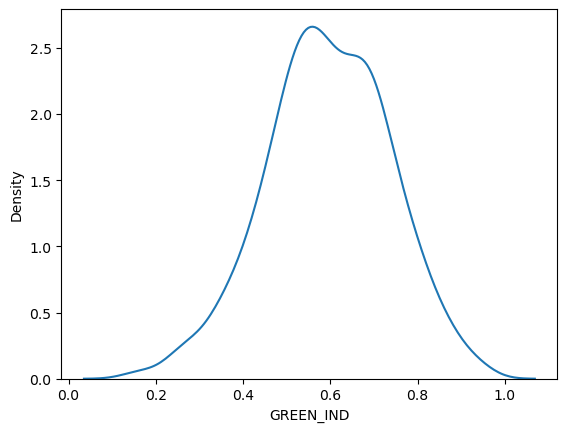

In [30]:
# plotting the distribution
import seaborn as sns
sns.kdeplot(greenwashing_ind[greenwashing_ind["GREEN_IND"]<0.96]["GREEN_IND"])
print(f"Number of obs above mean: {len(greenwashing_ind[greenwashing_ind["GREEN_IND"]>greenwashing_ind["GREEN_IND"].mean()])}")

In [25]:
# merge the data to characteristics 
merged = greenwashing_2017.merge(greenwashing_ind, left_on="NAME_SCRAPED", right_on="NAME").drop_duplicates("NAME_x")

merged["T"] = np.where(merged["GREEN_IND"] >=merged["GREEN_IND"].mean(), 1, 0)


In [ ]:
# merge the data to the returns
merged = merged.merge(data_abnormal_returns_w, left_on="NAME_x", right_on="NAME")

# get all rows where there is not a single na in the grouped rows
test = merged.groupby("NAME_x").filter(lambda x: ~x["NORMAL_RETURN"].isna().any())
test = test.groupby("NAME_x").filter(lambda x: ~x["STOCK_LOG_RETURN"].isna().any())

test = test[(test["DATE"] >= datetime.strptime('2019-06-01', '%Y-%m-%d').date()) & (test["DATE"] < datetime.strptime('2020-01-01', '%Y-%m-%d').date())]


test.value_counts("NAME_x")

In [27]:
test["AR"] = test["STOCK_LOG_RETURN"] - test["NORMAL_RETURN"]
test["AR"] = test["AR"].astype(float)
test["CAR"] = test.groupby("NAME_x")["AR"].cumsum()
test["POST"] = np.where(test["DATE"]>=datetime.strptime('2019-09-01', '%Y-%m-%d').date(), 1, 0)
test["T"] = np.where(test["GREEN_IND"] >=test["GREEN_IND"].mean(), 1, 0)
test["TxPOST"] = test["POST"] * test["T"]
test["FIRM_TIME"] = test["NAME_x"].astype(str) + "_" + test['DATE'].astype(str)
test["FIRM_TIME"] = test["FIRM_TIME"].astype("category")
test["DATE"] = pd.to_datetime(test["DATE"])
test["const"] = 1

test = test[['NAME_x', "DATE", 'TxPOST','const', 'POST', "T", 'CAR', "FIRM_TIME"]]
test = test.set_index(['NAME_x', 'DATE'])

In [28]:
from linearmodels.panel import PanelOLS
# from linearmodels.panel import compare

# index must be MultiIndex (firm, time)


y = test['CAR']
X = test[['const','TxPOST']]


# ----- firm × time FE ------ 
# put the interaction key in 'other_effects'
res_ft = PanelOLS(y, X, entity_effects=True,
               time_effects=True).fit(
            cov_type='clustered', cluster_entity=True)

print(res_ft)
# res_ft.summary()
# print(compare({'Two-way': res_2w, 'Firm×Time': res_ft}))

                          PanelOLS Estimation Summary                           
Dep. Variable:                    CAR   R-squared:                        0.0025
Estimator:                   PanelOLS   R-squared (Between):              0.0022
No. Observations:               13390   R-squared (Within):               0.0034
Date:                Mon, Apr 28 2025   R-squared (Overall):              0.0025
Time:                        17:06:00   Log-likelihood                 1.518e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      31.858
Entities:                         515   P-value                           0.0000
Avg Obs:                       26.000   Distribution:                 F(1,12849)
Min Obs:                       26.000                                           
Max Obs:                       26.000   F-statistic (robust):             2.8469
                            

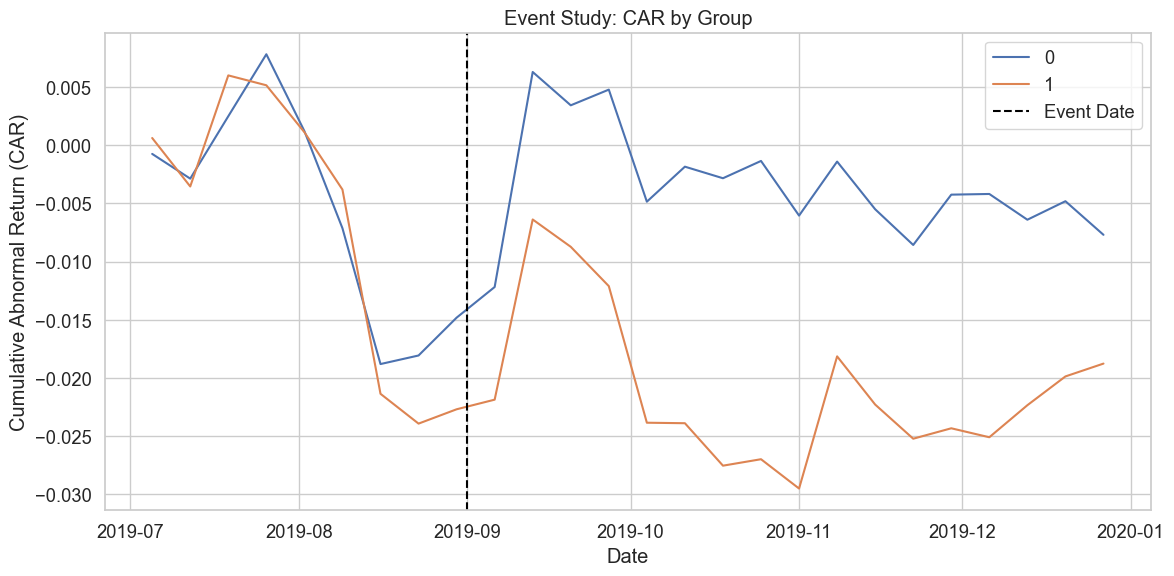

In [31]:
import matplotlib.pyplot as plt

# event study
event_stud = test.reset_index().groupby(["T", 'DATE']).mean("CAR").reset_index()


sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))
event_date = datetime.strptime('2019-09-01', '%Y-%m-%d').date()
sns.lineplot(data=event_stud, x='DATE', y='CAR', hue='T')
plt.axvline(event_date, color='black', linestyle='--', label='Event Date')


plt.title('Event Study: CAR by Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Abnormal Return (CAR)')
plt.legend()
plt.tight_layout()
plt.show()